# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных 

Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 

- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv
- /datasets/geo_data_2.csv

Данные содержат:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## План работы

Работа устроена следующим образом:
- В первой главе загружаем данные и проводим предобработку.
- Во второй главе проводим анализ данных. Строим гистограммы, смотрим корреляции и диаграммы рассеянья.
- Глава 3 посвещена обучению линейных моделей для предсказания целевого признака product.
- 4я глава отводится на подготовку к расчету прибыли и рисков.
- В 5й главе происходит сам расчет с помошью бутстрапа. Так же находим доверительные интервалы для расчетных величин.
- В последней главе делаем общие выводы по результатам работы.

## Загрузка и подготовка данных

### Загрузка библиотек

In [47]:
!pip install phik -q
!pip install shap -q
!pip install scikit-learn==1.4.2 -q
!pip install matplotlib==3.5.3 -q
!pip install seaborn==0.13.2 -q

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    StandardScaler
) 

from sklearn.linear_model import LinearRegression

import seaborn as sns

### Загрузка данных

In [49]:
data = []
for i in range(0,3):
    path = f'/datasets/geo_data_{i}.csv'
    if os.path.exists(path):
        data.append(pd.read_csv(path,index_col='id'))
        print(f'data_{i}')
        display(data[i].head())
    else:
        print('Ошибка')

data_0


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


data_1


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


data_2


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


In [50]:
for i in range(0,3):
    print(f'data_{i}')
    display(data[i].info())

data_0
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

data_1
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

data_2
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

### Предобработка 

Поскольку пропусков в данных нет, типы правильные. То предобработка сводится к поиску дубликатов и аномалий.

#### Дубликаты

In [51]:
for i in range(0,3):
    print(f'data_{i}')
    display(data[i].index.duplicated().sum())

data_0


10

data_1


4

data_2


4

In [52]:
for i in range(0,3):
    print(f'data_{i}')
    display(data[i].duplicated().sum())

data_0


0

data_1


0

data_2


0

Полных дубликатов нет, но есть дубликаты по id это не хорошо, но в данной работе не важно. 

#### Аномалии

In [53]:
for i in range(0,3):
    print(f'data_{i}')
    display(data[i].describe())

data_0


,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


data_1


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


data_2


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


Аномальных значений не найдено.

### Вывод

Данные соответствуют описанию и готовы к иследовательскому анализу.

## Анализ данных

Построим гистограммы для всех столбцов и посмотрим на распределения.

------------------------
data_0


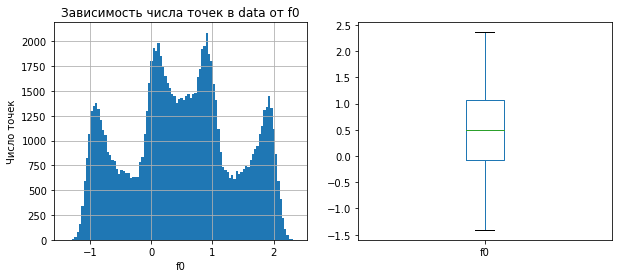

p=4.44e-29 Вероятно не нормальное


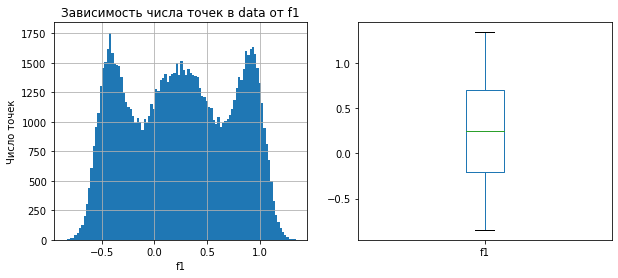

p=1.54e-34 Вероятно не нормальное


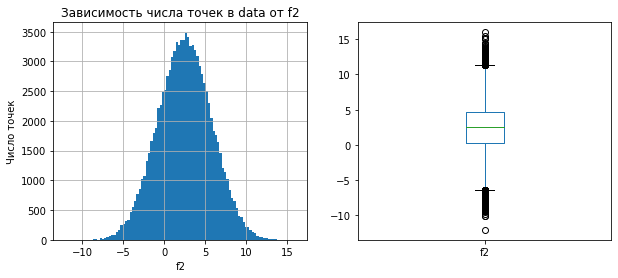

p=0.039 Вероятно не нормальное


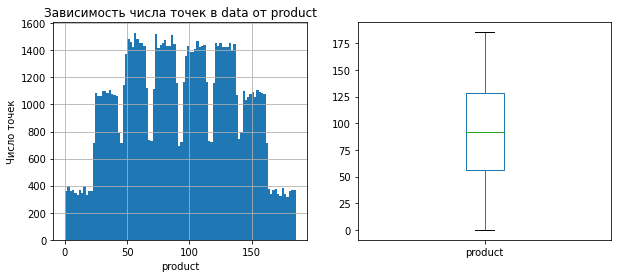

p=1.55e-25 Вероятно не нормальное
                 f0            f1            f2       product
count  99990.000000  99990.000000  99990.000000  99990.000000
mean       0.500454      0.250141      2.502629     92.499684
std        0.871844      0.504430      3.248149     44.288304
min       -1.408605     -0.848218    -12.088328      0.000000
25%       -0.072572     -0.200877      0.287784     56.497069
50%        0.502405      0.250252      2.515969     91.847928
75%        1.073626      0.700640      4.715035    128.563699
max        2.362331      1.343769     16.003790    185.364347
------------------------
data_1


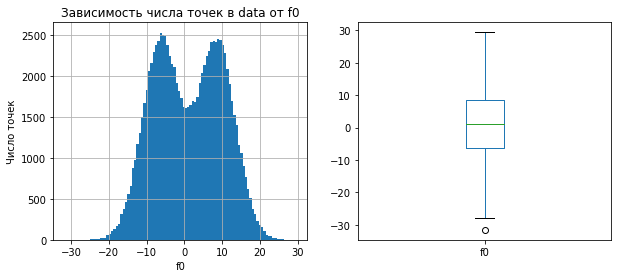

p=2.81e-26 Вероятно не нормальное


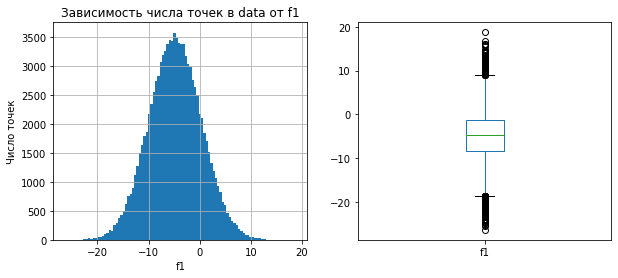

p=0.623 Вероятно нормальное


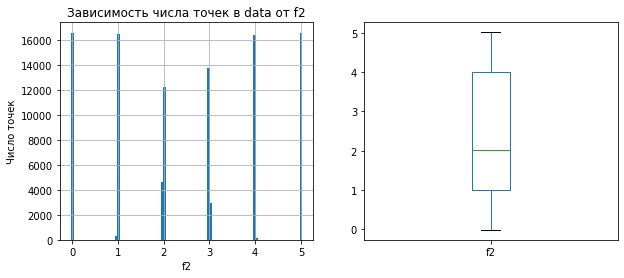

p=2.8e-45 Вероятно не нормальное


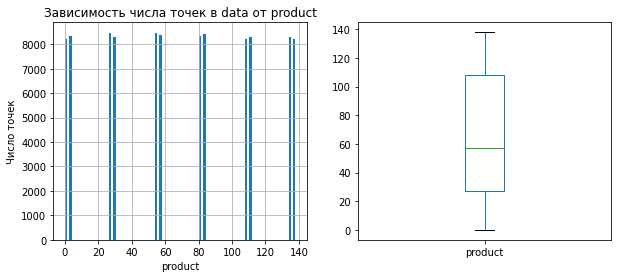

p=1.54e-44 Вероятно не нормальное
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       1.141209     -4.796608      2.494501     68.823916
std        8.965815      5.119906      1.703579     45.944663
min      -31.609576    -26.358598     -0.018144      0.000000
25%       -6.298551     -8.267985      1.000021     26.953261
50%        1.153055     -4.813172      2.011475     57.085625
75%        8.620964     -1.332816      3.999904    107.813044
max       29.421755     18.734063      5.019721    137.945408
------------------------
data_2


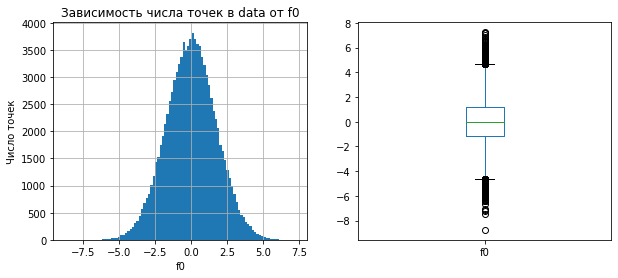

p=0.782 Вероятно нормальное


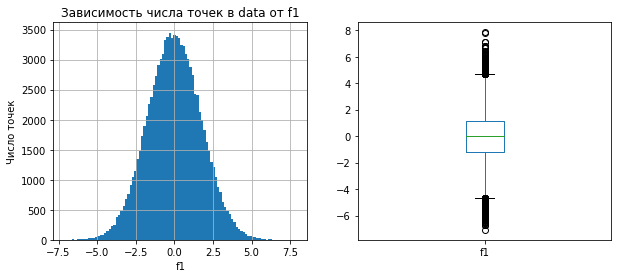

p=0.395 Вероятно нормальное


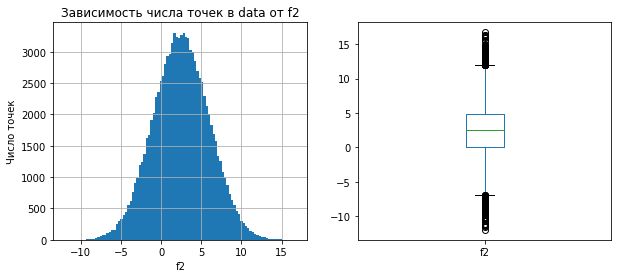

p=0.503 Вероятно нормальное


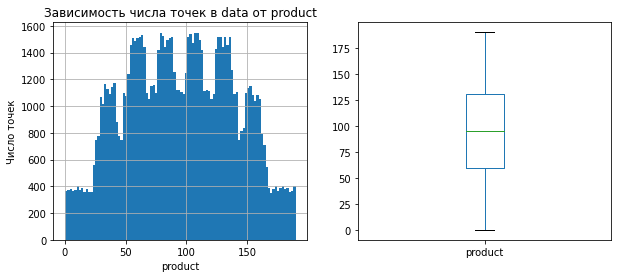

p=5.38e-22 Вероятно не нормальное
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       0.002002     -0.002159      2.495084     94.998342
std        1.732052      1.730397      3.473482     44.749573
min       -8.760004     -7.084020    -11.970335      0.000000
25%       -1.162328     -1.174841      0.130269     59.450028
50%        0.009424     -0.009661      2.484236     94.925026
75%        1.158477      1.163523      4.858720    130.586815
max        7.238262      7.844801     16.739402    190.029838


In [54]:
def analysis(df):
    con = df.select_dtypes(include=['float']).columns.tolist()
    
    for i in con:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        df[i].hist(bins=100)
        plt.title(f'Зависимость числа точек в data от {i}')
        plt.xlabel(i)
        plt.ylabel('Число точек')
    
        plt.subplot(1,2,2)
        df[i].plot(kind='box')
        plt.title('')
        plt.ylabel('')
    
    
        plt.show()
    
        stat, p = shapiro(df[i].sample(n=4500))
        if p>0.05:
            print(f'p={p:.3} Вероятно нормальное')
        else :
            print(f'p={p:.3} Вероятно не нормальное')
    
    print(df[con].describe())
    
   
for i in range(0,3):
    print('------------------------')
    print(f'data_{i}')
    analysis(data[i])

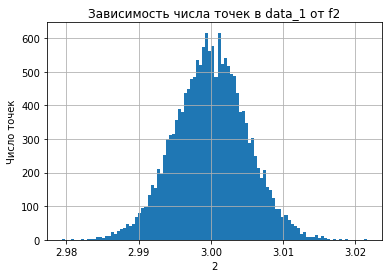

In [55]:
(data[1]).loc[(data[1]['f2']>2.5)&(data[1]['f2']<3.5),'f2'].hist(bins=100)
plt.title(f'Зависимость числа точек в data_1 от f2')
plt.xlabel(i)
plt.ylabel('Число точек')
plt.show()

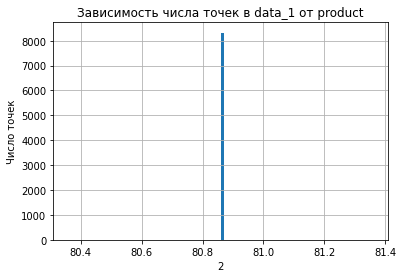

In [56]:
(data[1]).loc[(data[1]['product']>80)&(data[1]['product']<81),'product'].hist(bins=100)
plt.title(f'Зависимость числа точек в data_1 от product')
plt.xlabel(i)
plt.ylabel('Число точек')
plt.show()

### Вывод

Видно что распределения данных в файлах сильно отличаются.
- data_0
    - f0 не нормальное 4 пика
    - f1 не нормальное 3 пика
    - f2 нормальное распеделение
    - product не нормальное несколько пиков
- data_1
    - f0 ненормальное 2 пика. Похоже на сумму 2х нормальных распределений.
    - f1 нормальное распеделение
    - f2 похоже на сумму узких нормальных распределений с средними 0,1...,5 
    - product почти дискретные значения.
- data_1
    - f0 нормальное распеделение
    - f1 нормальное распеделение
    - f2 нормальное распеделение
    - product ненормальное с несколькими пиками.

## Корреляционный анализ

Поскольку величины распределены во многих случаях не нормально посмотрим корреляцию Спирмана.

------------------------
data_0


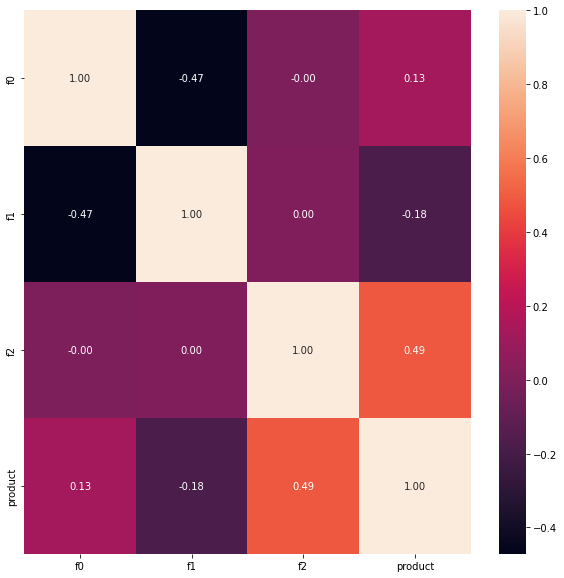

------------------------
data_1


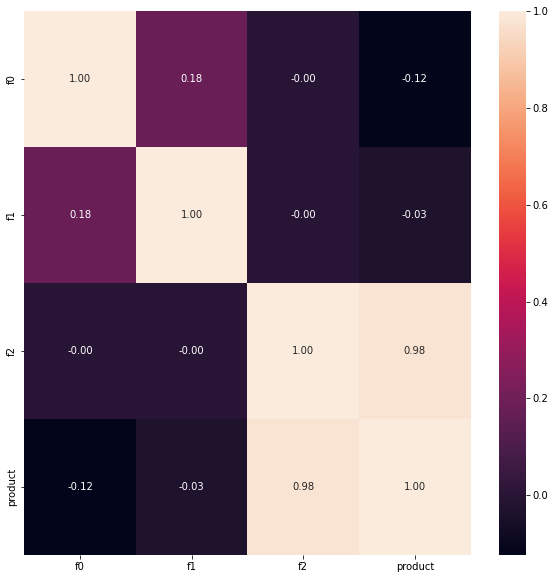

------------------------
data_2


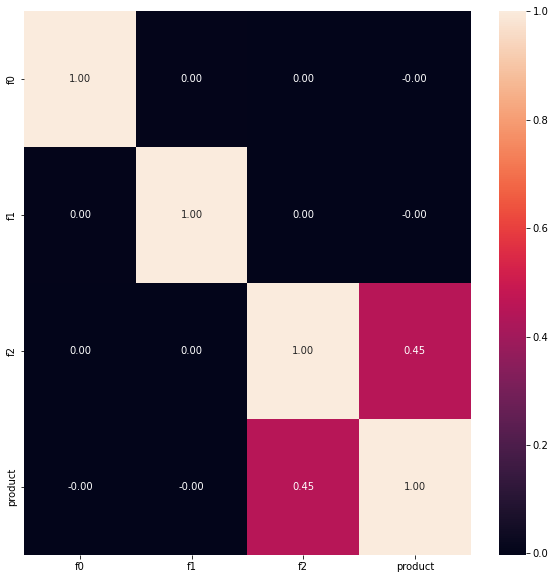

In [57]:


for i in range(0,3):
    print('------------------------')
    print(f'data_{i}')
    plt.figure(figsize=(10,10))
    sns.heatmap(data[i].corr(method='spearman'),annot=True, fmt='.2f')
    plt.show()

Посмотрим так же матрицу рассеяния.

------------------------
data_0


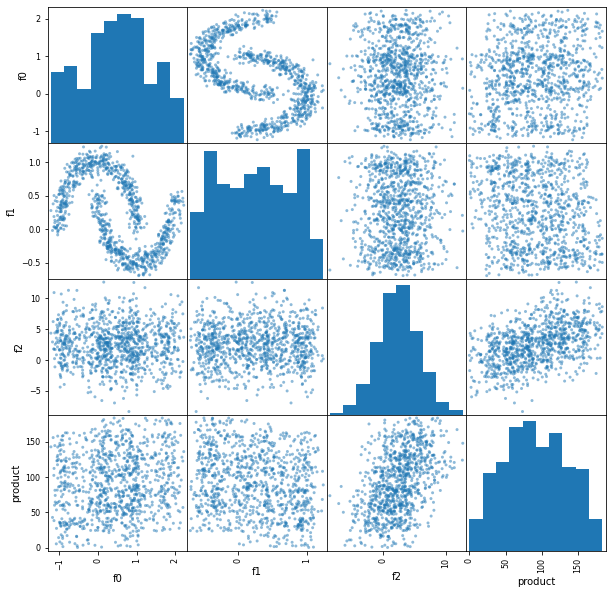

------------------------
data_1


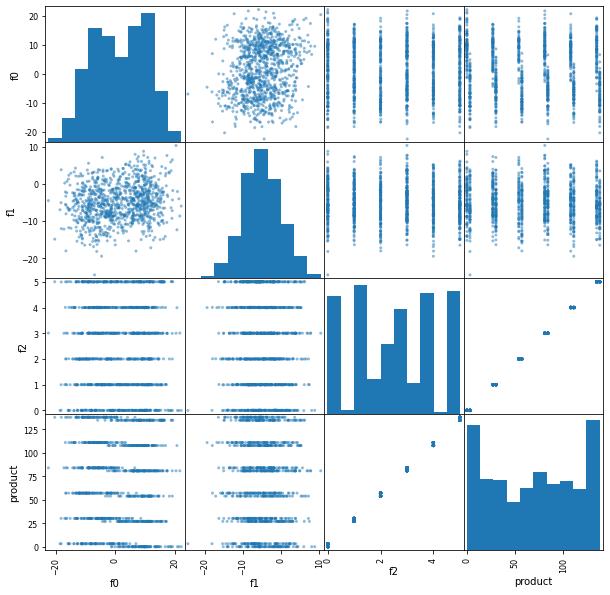

------------------------
data_2


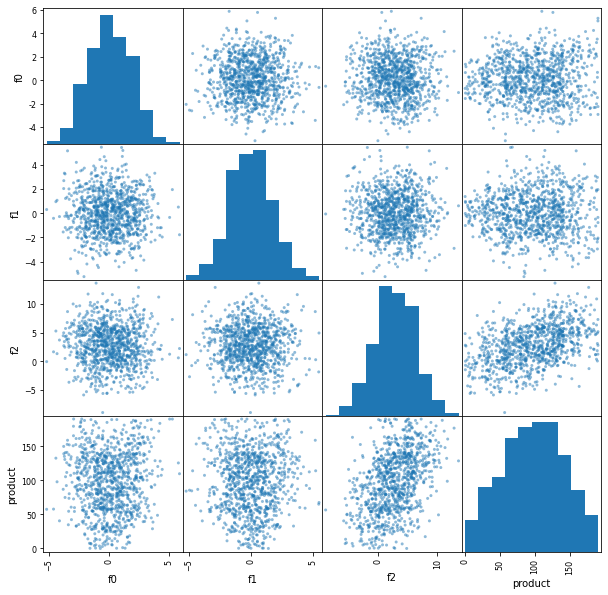

In [58]:
for i in range(0,3):
    print('------------------------')
    print(f'data_{i}')
    pd.plotting.scatter_matrix(data[i].sample(1000),figsize=(10,10))
    plt.show()

### Вывод

В data_0 видим интересную нелинейную зависимость f0 от f1.

Датасет data_1 выглядит очень подозрительно. 
- Реальные данные по скважинам не могут быть настолько дискретными. Это и не округление т.к. разброс значений присутствует. 
- product фактически является линейной функцией f2.
Вероятно это следствие какой-то ошибки при сборе данных. Или кто то просто не очень умело их нарисовал.


data_2 никаких особых проблем не видно , кроме слабовыраженой зависимости целевого признака.

Во всех случаях понятно что основной признак, который связан с product это f2. 

## Обучение и проверка модели

Обучаем линейные модели.

In [59]:
num = ['f0','f1','f2']
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [60]:
def split(data):
    X = data.drop(['product'],axis=1)
    y = data['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

In [61]:
def model(data):
    X_train, X_test, y_train, y_test = split(data)
    pipe_final.fit(X_train,y_train)
    y_test_pred = pipe_final.predict(X_test)
    coef = pipe_final.named_steps['models'].coef_
    return y_test_pred, coef

In [62]:
def residual_test(data):
    prediction = model(data)[0]
    y_test = split(data)[3]
    score = (mean_squared_error(y_test,prediction))**(0.5)
    residual = (y_test-prediction)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residual,bins=30)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_ylabel('Число точек')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(y=residual,x=prediction, alpha=0.01)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    print('RMSE', score)
    print(residual.describe())
    return 

Сохраняем предсказания и значения валидационной выборки.

In [63]:
y_pred = []
y_true = []
coef = []
print(data[i].columns)
for i in range(0,3):
    print('------------------------')
    print(f'data_{i}')
    y_true.append(split(data[i])[3])
    y_pred.append(model(data[i])[0])
    coef.append(model(data[i])[1])
    print(coef[i])

Index(['f0', 'f1', 'f2', 'product'], dtype='object')
------------------------
data_0
[ 3.20190496 -7.12848396 21.43470515]
------------------------
data_1
[-1.29887956 -0.11181872 45.90761025]
------------------------
data_2
[-0.09591536 -0.14252365 20.02809363]


------------------------
data_0
Средний предсказанный обьем сырья 92.60984027552017


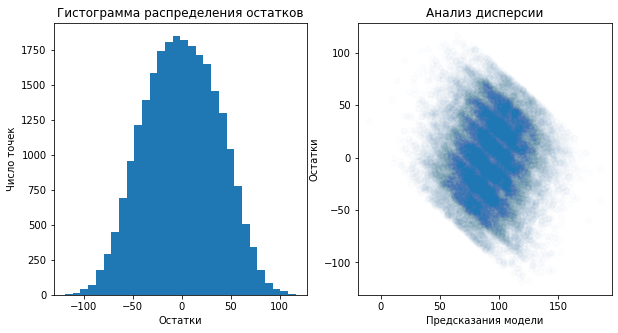

RMSE 37.68508926201444
count    24998.000000
mean        -0.221074
std         37.685195
min       -119.015405
25%        -27.918951
50%         -0.342652
75%         27.687719
max        116.421935
Name: product, dtype: float64
None
------------------------
data_1
Средний предсказанный обьем сырья 68.57703454115173


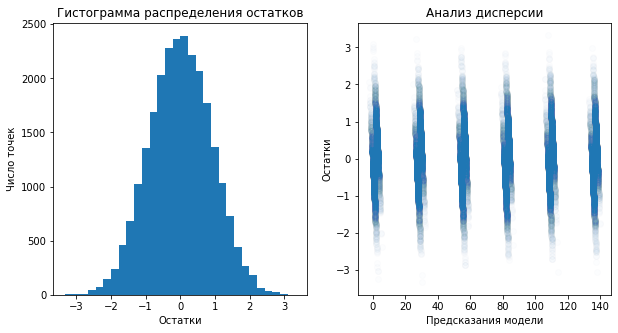

RMSE 0.8928265978121422
count    24999.000000
mean         0.006581
std          0.892820
min         -3.330749
25%         -0.608305
50%          0.006334
75%          0.625201
max          3.322217
Name: product, dtype: float64
None
------------------------
data_2
Средний предсказанный обьем сырья 94.93478722287514


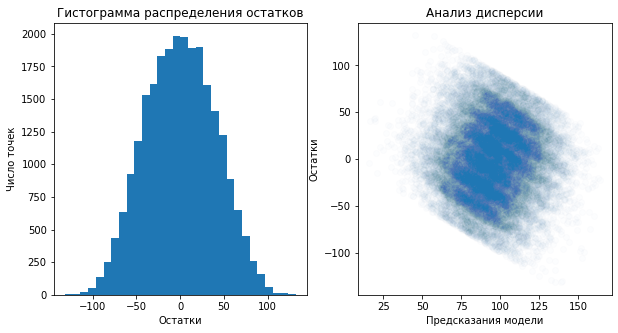

RMSE 40.080822438088305
count    24999.000000
mean         0.319849
std         40.080348
min       -131.512147
25%        -29.112565
50%          0.257022
75%         29.104057
max        131.957180
Name: product, dtype: float64
None


In [64]:
for i in range(0,3):
    print('------------------------')
    print(f'data_{i}')
    print(f'Средний предсказанный обьем сырья {y_pred[i].mean()}')
    print(residual_test(data[i]))

### Вывод

Величина RMSE для 1 и 3 модели довольно высокие. Остатки распределены не равномерно во всех 3 случаях.

## Подготовка к расчёту прибыли

Введем параметры.

In [65]:
WELL_SAMPLE_SIZE = 500 # Число исследуемых скважин.
WELL_BEST = 200 # Число отбираемых лучших скважин.
TOTAL = 10000 # Бюджет млн.р.
WELL_K = 0.45 # Прибыль с единицы product млн.р.
RISK_RATIO = 0.025 # Риск убытка

Цена одной скважины млн.руб.

In [66]:
TOTAL/WELL_BEST

50.0

Для безубыточности со скважины нужно добыть тысяч барелей

In [67]:
round(TOTAL/WELL_BEST/WELL_K)

111

При этом средние запасы в регионе.

In [68]:
for i in range(0,3):
    print(f'data_{i} ', round(data[i]['product'].mean()))

data_0  92
data_1  69
data_2  95


### Вывод

Для безубыточности нужно добывать в среднем 111т.барелей со скважины. Средние запасы по регионам ниже 93, 69, 95 т.барелей

## Расчёт прибыли и рисков 

Функция для подсчета прибыли реальной и предсказаной

In [115]:
def profit(y_true,y_pred):
    y_pred_best = y_pred.reset_index(drop=True).sort_values(ascending=False).head(WELL_BEST)
    y_true_best = y_true.reset_index(drop=True)[y_pred_best.index]
    profit_pred = y_pred_best.sum()*0.45-10000
    profit_true = y_true_best.sum()*0.45-10000
    return profit_true, profit_pred

Расчет прибыли и риска с Bootstrap по 1000 выборок.

In [116]:
def profit_bts(y_pred,y_true):
    state = np.random.RandomState(12345)
    profit_true_arr = []
    profit_pred_arr =[]
    y_pred = pd.Series(y_pred)
    y_true = y_true.reset_index(drop=True)
    for i in range(0,1000):
        y_pred_sample = y_pred\
        .sample(n=WELL_SAMPLE_SIZE, replace=True ,random_state=state)
        y_true_sample = y_true[y_pred_sample.index]
        profit_true, profit_pred = profit(y_true_sample, y_pred_sample)
        profit_pred_arr.append(profit_pred)
        profit_true_arr.append(profit_true) 
    df_profit = pd.DataFrame(data={'true':profit_true_arr,'pred':profit_pred_arr})
    df_profit['res'] = df_profit['true']-df_profit['pred']
    return df_profit

Изобразим на гистограмах результаты использования бутстрапа.

data_0


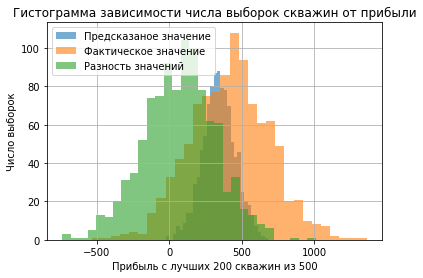

data_1


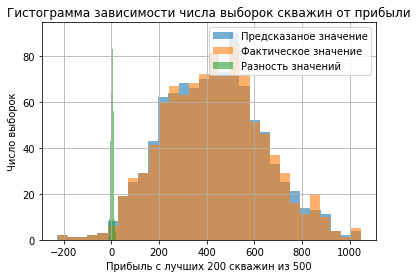

data_2


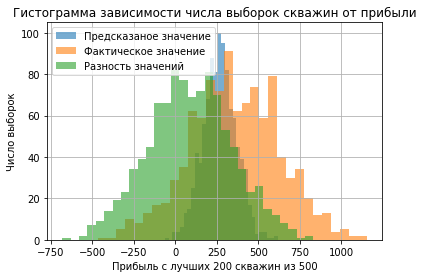

In [117]:
df_profit = []
for i in range(0,3):
    print(f'data_{i}')
    df_profit.append(profit_bts(y_pred[i],y_true[i]))
    df_profit[i]['pred'].hist(bins=30, alpha=0.6,label='Предсказаное значение')
    plt.xlabel('Прибыль с лучших 200 скважин из 500')
    plt.ylabel('Число выборок')
    plt.title('Гистограмма зависимости числа выборок скважин от прибыли')
    df_profit[i]['true'].hist(bins=30, alpha=0.6,label='Фактическое значение')
    df_profit[i]['res'].hist(bins=30, alpha=0.6,label='Разность значений')
    plt.legend()
    plt.show()

Видно что оценка получилась смещенная. 
Вероятность убытка.

### Вероятность убытка.

Посчитаем долю случаев в которых прибыль оказалась отрицательной это и будет риск убытка.

In [120]:
for i in range(0,3):
    print(f'Риск убытка в data_{i}')
    print((df_profit[i]['true']<0).sum()/1000)

Риск убытка в data_0
0.059
Риск убытка в data_1
0.01
Риск убытка в data_2
0.089


### Доверительный интервал для средней прибыли.

Посчитаем 95% доверительный интервал для средней прибыли и среднюю прибыль.

- Интервал для истинных значений.

In [122]:
for i in range(0,3):
    print(f'Cредяя фактическая прибыль data_{i}')
    print(round(df_profit[i]['true'].sum()/1000,2))
    print(f'95% доверительный интервал фактической средней прибыли data_{i}')
    print(round(df_profit[i]['true'].quantile(0.025),2),\
          '-',round(df_profit[i]['true'].quantile(0.975),2))
    print('------------------------')

Cредяя фактическая прибыль data_0
417.35
95% доверительный интервал фактической средней прибыли data_0
-96.26 - 933.49
------------------------
Cредяя фактическая прибыль data_1
432.02
95% доверительный интервал фактической средней прибыли data_1
51.74 - 863.04
------------------------
Cредяя фактическая прибыль data_2
356.88
95% доверительный интервал фактической средней прибыли data_2
-186.26 - 892.1
------------------------


### Вывод.

Разультаты расчетов по предсказанию моделей с помошью бутстапа оказались смещенными. Однако распределения остатков выглядит правильно. Поэтому предсказания модели будем использовать только для выбора 200 лучших точек из 500. Данные же по прибыли и риску будем брать фактические. Таким образом
лучший регион под номером 1. Риск убытка 0.1%. Средняя прибыль в этом регионе 432.02 млн.р. 95% Доверительный интервал 51.74 - 863.04 млн.р.

## Вывод

Были загружены и проверенны на корректность данные. 
В 3 и 4 главе были осисаны особенности распределения и взаимной кореляции признаков.
Так ,например, было замечено, в втором датасете product почти коллинеарен c признаком f2 с коэффициентом корреляции Спирмена 0.98. а в 1 датасете между f1 и f0 прослеживается четкая нелинейная связь.
Распределения данных в 1 и 2 датасете далеки от нормальных. Что наводит на мысль , что данные не отражают реальность. Т.к. Запас скважинах не может быть дискретной величиной а дискретность целевого признака наблюдается во всех регионах.

Данные были разбиты на обучающую и валидационую в соотношении 3/1. На обучающей выборке были обучены 3 модели линейной регрессии. (Хотя взаимосвязь данных нелинейна и, вероятно, другие модели могли бы работать лучше , но важна интерпретируемость модели.)

Для валидационной выборки были предсказаны целевые значения. 
- Первый регион RMSE = 37.8т.баррелей при среднем 92.4 т.баррелей
- Второй регион RMSE = 0.9 т.баррелей при среднем 68.7 т.баррелей
- Третий регион RMSE = 40.1 т.баррелей при среднем 94.8 т.баррелей

При этом для безубыточности средний запас в скважине должен составлять 111 т.баррелей

Затем была применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли и выявить максимально выгодный регион для разработки. Для прибыли с 200 лучших точек из 500 получились следующие значения

- Первый регион средняя прибыль 417.35млн.р. риск убытка 5.9% 95% доверительный интервал -96.26 - 933.49 млн.р.
- Второй регион средняя прибыль 432.02млн.р. риск убытка 1% 95% доверительный интервал 51.74 - 863.04 млн.р.
- Третий регион средняя прибыль 356.88млн.р. риск убытка 8.9% 95% доверительный интервал -186.26 - 892.1 млн.р.

Таким благодаря более точному прогнозу самым выгодным регионом оказался второй , при том, что средние запасы там значительно ниже.

Рекомендации:
- Проверить алгоритм присвоения ID скважинам т.к. есть дубликаты.
- Проверить корректность данных в которых наблюдается дискретность.